# import module

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
from glob import glob

import tensorflow as tf
import numpy as np
from tensorflow.keras import backend as keras_backend
import segmentation_models as sm

from src.data_loader.segmentation import SegDataloader

sm.set_framework ('tf.keras')

Segmentation Models: using `keras` framework.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\gr300\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3437, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-85e571815844>", line 10, in <module>
    from src.data_loader.segmentation import SegDataloader
  File "D:\Works\jupyterlab\CNN_total\src\data_loader\segmentation.py", line 8, in <module>
    from .base_loader import BaseDataGetter, BaseDataLoader, \
  File "D:\Works\jupyterlab\CNN_total\src\data_loader\base_loader.py", line 8, in <module>
    from sklearn.utils import shuffle as syncron_shuffle
  File "C:\Users\gr300\anaconda3\lib\site-packages\sklearn\__init__.py", line 82, in <module>
    from .base import clone
  File "C:\Users\gr300\anaconda3\lib\site-packages\sklearn\base.py", line 17, in <module>
    from .utils import _IS_32BIT
  File "C:\Users\gr300\anaconda3\lib\site-packages\sklearn\utils\__init__.py", line 23, in <module>
    from .class_weight import com

TypeError: object of type 'NoneType' has no len()

In [2]:
gpu_on = True

if gpu_on :
    gpu_devices = tf.config.experimental.list_physical_devices("GPU")
    for device in gpu_devices:
        tf.config.experimental.set_memory_growth(device, True)
else:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
    gpu_devices = tf.config.experimental.list_physical_devices("CPU")

print(gpu_devices)

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
from src.data_loader.segmentation import SegDataloader
from glob import glob

BACKBONE="inceptionv3"

task = "segmentation"
data_set_name = "glomerulus_0.65_1024_remove_peel_split_man"
batch_size = 8
on_memory = True
argumentation_proba = 0
preprocess_input = sm.get_preprocessing(BACKBONE)
target_size = (512,512)
interpolation = "bilinear"
dtype = "float32"


train_image_path_list = glob(f"./datasets/{task}/{data_set_name}/train/image/*")
train_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/train/mask/*")

valid_image_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/image/*")
valid_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/valid/mask/*")

test_image_path_list = glob(f"./datasets/{task}/{data_set_name}/test/image/*")
test_mask_path_list = glob(f"./datasets/{task}/{data_set_name}/test/mask/*")

train_data_loader = SegDataloader(image_path_list=train_image_path_list,
                                  mask_path_list=train_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=argumentation_proba,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
valid_data_loader = SegDataloader(image_path_list=valid_image_path_list,
                                  mask_path_list=valid_mask_path_list,
                                  batch_size=batch_size,
                                  on_memory=on_memory,
                                  argumentation_proba=0,
                                  preprocess_input=preprocess_input,
                                  target_size=target_size,
                                  interpolation=interpolation,
                                  shuffle=True,
                                  dtype=dtype
                                  )
test_data_loader = SegDataloader(image_path_list=test_image_path_list,
                                 mask_path_list=test_mask_path_list,
                                 batch_size=1,
                                 on_memory=False,
                                 argumentation_proba=0,
                                 preprocess_input=preprocess_input,
                                 target_size=target_size,
                                 interpolation=interpolation,
                                 shuffle=False,
                                 dtype=dtype
                                 )

 [4600/4600] |##############################################| (Time:  0:02:14) 
 [06/415] |                                                 | (ETA:   0:00:12) 

Total data num 4600


 [415/415] |################################################| (Time:  0:00:11) 


Total data num 415
Total data num 1111


In [5]:
np.random.seed(1337)  # for reproducibility

epoch_release_frozen =10

# create the base pre-trained model~
model = sm.Unet(backbone_name=BACKBONE, input_shape=(
            None, None, 3), classes=1, activation='sigmoid')

In [14]:
from datetime import date

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau, LearningRateScheduler
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras.optimizers import Nadam

from src.util.custom_loss import WeightedRegionLoss, TverskyLoss, dice_score, dice_loss
from segmentation_models.losses import DiceLoss, BinaryFocalLoss

today = date.today()

# YY/MM/dd
today_str = today.strftime("%Y-%m-%d")
today_weight_path = f"./weights/{task}/{data_set_name}/{today_str}/target_size_{target_size}/" 
today_logs_path = f"./logs/{task}/{data_set_name}/{today_str}/target_size_{target_size}/"
os.makedirs(today_weight_path, exist_ok=True)
os.makedirs(today_logs_path, exist_ok=True)
optimizer = Nadam(1e-4, clipnorm=1)

save_c = ModelCheckpoint(
    today_weight_path+"/weights_{val_loss:.4f}_{loss:.4f}_{epoch:02d}.hdf5",
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=True,
    mode='min')


reduceLROnPlat = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=20,
    verbose=1,
    mode="auto",
    min_delta=0.0001,
    cooldown=5,
    min_lr=1e-7)
csv_logger = CSVLogger(f'{today_logs_path}/log.csv', append=False, separator=',')


def make_model_trainable(epoch, model, target_epoch):
    if epoch > target_epoch:
        for layer in model.layers:
            layer.trainable = True
            
make_trainable_callback = LambdaCallback(
    on_epoch_begin=lambda epoch,logs: make_model_trainable(epoch, model, target_epoch=epoch_release_frozen)
)
def warm_up_learning_rate_scheduler(
    epoch, learning_rate, warm_up_epoch=20
):
    print(epoch)
    print(learning_rate)
    if epoch < warm_up_epoch:
        learning_rate = learning_rate * ((epoch + 1) / warm_up_epoch)
    
    return learning_rate

warm_up_lr_scheduler = LearningRateScheduler(warm_up_learning_rate_scheduler, verbose=1)


model.compile(optimizer=optimizer, loss=DiceLoss(per_image=True) + BinaryFocalLoss(), metrics=[dice_score])

In [15]:
start_epoch = 0
epochs = 200

model.fit(
    train_data_loader,
    validation_data=valid_data_loader,
    epochs=epochs,
    callbacks=[reduceLROnPlat, save_c, csv_logger, make_trainable_callback, warm_up_lr_scheduler],
    initial_epoch=start_epoch
)

Epoch 1/200
0
9.999999747378752e-05

Epoch 00001: LearningRateScheduler reducing learning rate to 4.999999873689376e-06.
575/575 [==============================] - 294s 477ms/step - loss: 1.0023 - dice_score: 0.1560 - val_loss: 0.9722 - val_dice_score: 0.2227
Epoch 2/200
1
4.999999873689376e-06

Epoch 00002: LearningRateScheduler reducing learning rate to 4.999999873689376e-07.
110/575 [====>.........................] - ETA: 3:31 - loss: 0.9423 - dice_score: 0.2488

KeyboardInterrupt: 

# Unused Code

In [22]:
from matplotlib import pyplot as plt
import albumentations as A

In [23]:
model.load_weights("./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/blur/weights/weights_0.0042_0.0031_49.hdf5")

In [24]:
index = 543

data = test_data_loader[index]

image_array = data[0][0]
predicted_array = model.predict(np.expand_dims(image_array, axis=0))[0]

image_array = (image_array + 1) * 127.5
image_array = image_array.astype("uint8")
# predicted_array = (predicted_array) * 127.5
# predicted_array = predicted_array.astype("uint8")

mask_array = data[1][0]
mask_array = (mask_array) * 255
mask_array = mask_array.astype("uint8")

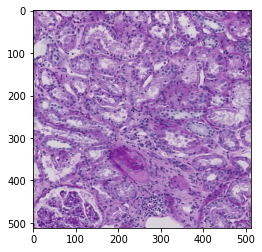

In [25]:
plt.imshow(image_array)

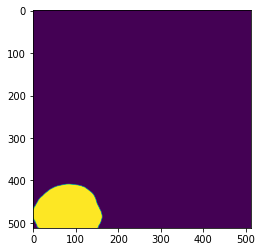

In [26]:
plt.imshow(predicted_array)

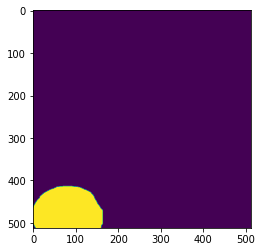

In [27]:
plt.imshow(mask_array)

In [3]:
import csv

with open('./results/segmentation/glomerulus_0.65_1024_remove_peel_split_man/(512,512)/blur/log.csv') as csv_file:
    reader = csv.DictReader(csv_file)
    dict_from_csv = {field_name:[] for field_name in reader.fieldnames}
    print(reader.fieldnames)
    for row in reader:
        for filedname in reader.fieldnames:
            dict_from_csv[filedname].append(float(row[filedname])) 

['epoch', 'dice_score', 'loss', 'lr', 'val_dice_score', 'val_loss']


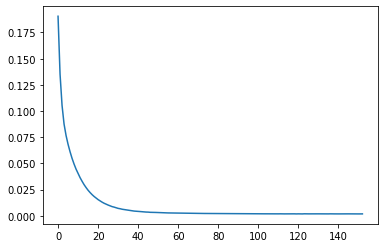

In [4]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["loss"])
plt.show()

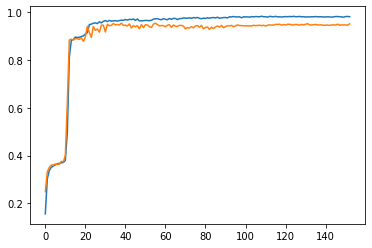

In [5]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["dice_score"])
plt.plot(dict_from_csv["val_dice_score"])
plt.show()

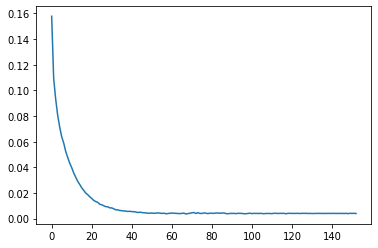

In [6]:
from matplotlib import pyplot as plt

plt.plot(dict_from_csv["val_loss"])
plt.show()